###**Problem Statement**

The goal is to develop a machine learning model that accurately identifies fraudulent transactions from a highly unbalanced dataset of European credit card transactions recorded in September 2013, which consists of 284,807 transactions.

In [ ]:
# Importing some common libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For statistical tests
import scipy.stats as stats

# For spilliting the data and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For sampling
from imblearn.over_sampling import SMOTE

# for model building
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# For evaluation
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.metrics import recall_score,precision_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reading the data
data=pd.read_csv('/content/drive/MyDrive/dataset/creditcard.csv')

In [ ]:
# First five rows
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.shape

(284807, 31)

In [ ]:
# Info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Checking for missing values
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

**Data has no missing values**

In [ ]:
# Checking for imbalance of the target variable
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

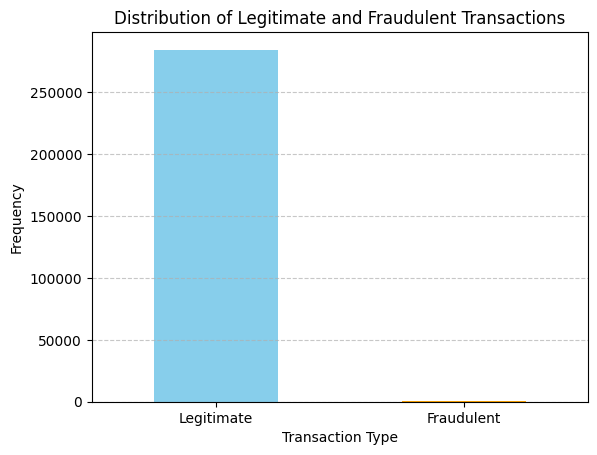

In [ ]:

# Plotting
data['Class'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])

# Adding enhancements
plt.title('Distribution of Legitimate and Fraudulent Transactions')  # Title
plt.xlabel('Transaction Type')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.xticks(ticks=[0, 1], labels=['Legitimate', 'Fraudulent'], rotation=0)  # Custom x-axis tick labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding a grid for better readability

# Show plot
plt.show()


 **We see that the target variable is highly imbalanced. We may have to imply oversampling techniques to counter this**

**Since the data is masked, doing exploratory Data Analysis wouldn't make sense**

**We will go ahead with feature selection**

##**Feature Selection**

In [ ]:
import pandas as pd
from scipy import stats



# Initialize an empty DataFrame to store the results
stat_df = pd.DataFrame(columns=['Feature', 'Pvalue'])

# Iterating over each feature column, excluding 'Class'
for feature in data.drop(columns='Class').columns:
    # Separating the data based on class
    class_1 = data[data['Class'] == 1][feature]
    class_0 = data[data['Class'] == 0][feature]

    # Performing t-test between the two classes for the current feature
    p_value = stats.ttest_ind(class_1, class_0, equal_var=False).pvalue  # equal_var=False for Welch's t-test

    # Appending the results to the DataFrame
    stat_df = stat_df.append({'Feature': feature, 'Pvalue': p_value}, ignore_index=True)

# Displaying the resulting DataFrame with features and their corresponding p-values
print(stat_df)


   Feature         Pvalue
0     Time   1.654564e-10
1       V1   5.491643e-45
2       V2   1.288580e-59
3       V3   4.786081e-75
4       V4  4.587317e-136
5       V5   1.497028e-33
6       V6   5.880378e-50
7       V7   4.292231e-52
8       V8   6.275812e-02
9       V9   1.193505e-79
10     V10   3.382884e-93
11     V11  4.577212e-120
12     V12  1.481317e-112
13     V13   2.842017e-02
14     V14  1.040151e-140
15     V15   4.993336e-02
16     V16   7.905326e-84
17     V17   1.558094e-71
18     V18   2.639223e-52
19     V19   6.707057e-21
20     V20   1.687689e-09
21     V21   4.882130e-05
22     V22   8.346792e-01
23     V23   5.710402e-01
24     V24   7.565213e-06
25     V25   2.487229e-01
26     V26   1.542128e-02
27     V27   6.129684e-03
28     V28   2.251207e-03
29  Amount   3.560519e-03


In [ ]:
selected_features=stat_df.loc[stat_df.Pvalue<0.05]['Feature'].values

**Base Model**

In [ ]:
# We will proceed with a base model of Logistic Regression

# Splitting the data
x=data[selected_features]
y=data.Class
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,stratify=y)

In [ ]:
x_train.shape,x_test.shape

((199364, 27), (85443, 27))

In [ ]:
# Scaling the data
sc=StandardScaler()
x_train_s=pd.DataFrame(sc.fit_transform(x_train),columns=x_train.columns)
x_test_s=pd.DataFrame(sc.transform(x_test),columns=x_test.columns)

In [ ]:
# Adding constant column in x_train and x_test
x_train_s=sm.add_constant(x_train_s)
x_test_s=sm.add_constant(x_test_s)

In [ ]:
y_train=y_train.reset_index().drop(columns='index')
y_test=y_test.reset_index().drop(columns='index')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluation(y_test, y_pred):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print evaluation metrics
    print('Evaluation Metrics:')
    print('-------------------')
    print(f'Accuracy Score: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print('\nClassification Report:\n', class_report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay(cm, display_labels=['Legitimate', 'Fraudulent']).plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.grid(False)
    plt.show()

# Evaluation function enhanced and ready for use


In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Fit the logistic regression model
base_model = sm.Logit(y_train, sm.add_constant(x_train_s)).fit()

# Get the predicted probabilities
y_pred_proba = base_model.predict(sm.add_constant(x_test_s))

# Summary of the model using summary2() for better formatting
model_summary = base_model.summary2()

# Display the summary
print(model_summary)


Optimization terminated successfully.
         Current function value: 0.004018
         Iterations 14
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: Class            Pseudo R-squared: 0.684    
Date:               2024-04-02 06:12 AIC:              1658.1589
No. Observations:   199364           BIC:              1943.8398
Df Model:           27               Log-Likelihood:   -801.08  
Df Residuals:       199336           LL-Null:          -2532.3  
Converged:          1.0000           LLR p-value:      0.0000   
No. Iterations:     14.0000          Scale:            1.0000   
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
const       -8.6209    0.1756  -49.0874  0.0000  -8.9651  -8.2767
Time        -0.0566    0.1196   -0.4729  0.6363  -0.2909   0.1778
V1     

In [ ]:
y_pred=[]

# Taking threshold for probability at 0.5
for i in y_pred_proba:
    if i>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

Evaluation Metrics:
-------------------
Accuracy Score: 0.9992
F1 Score: 0.7149
Precision: 0.8812
Recall: 0.6014

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.60      0.71       148

    accuracy                           1.00     85443
   macro avg       0.94      0.80      0.86     85443
weighted avg       1.00      1.00      1.00     85443



<Figure size 800x600 with 0 Axes>

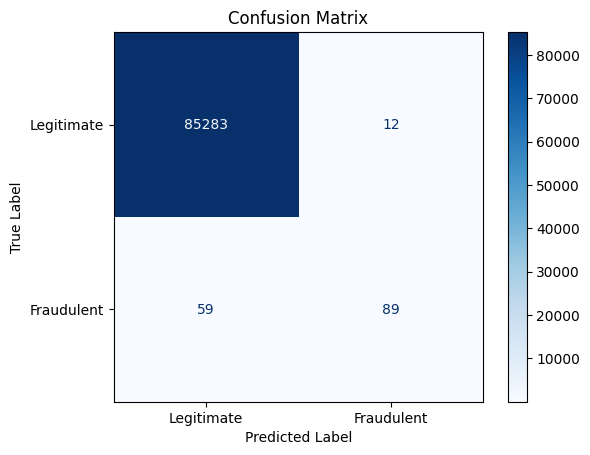

In [ ]:
# Evaluating the model
evaluation(y_test,y_pred)

We observe that we get an excellent accuracy score of 99.9% but a poor recall score. This due to the high imbalance in the target class. We will try some oversampling techniques to see if we can counter this.

###**SMOTE**

In [ ]:
# we now have an oversampled training set
# We will apply the Logistic regression model again
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

# Perform SMOTE resampling
x_train_sampled, y_train_sampled = SMOTE().fit_resample(x_train_s, y_train)

# Fit the logistic regression model
model = sm.Logit(y_train_sampled, sm.add_constant(x_train_sampled)).fit()

# Get the predicted probabilities
y_pred_proba = model.predict(sm.add_constant(x_test_s))

# Display the summary using summary2() for better formatting
model_summary = model.summary2()
print(model_summary)


Optimization terminated successfully.
         Current function value: 0.132760
         Iterations 14
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: Class            Pseudo R-squared: 0.808      
Date:               2024-04-02 06:25 AIC:              105743.3861
No. Observations:   398040           BIC:              106048.4267
Df Model:           27               Log-Likelihood:   -52844.    
Df Residuals:       398012           LL-Null:          -2.7590e+05
Converged:          1.0000           LLR p-value:      0.0000     
No. Iterations:     14.0000          Scale:            1.0000     
--------------------------------------------------------------------
          Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const    -3.5879     0.0156   -229.5118   0.0000   -3.6185   -3.5572
Time     -0.2537     0.0119    -21.2481   0.

In [ ]:
y_pred=[]

# Taking threshold for probability at 0.5
for i in y_pred_proba:
    if i>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

Evaluation Metrics:
-------------------
Accuracy Score: 0.9743
F1 Score: 0.1096
Precision: 0.0583
Recall: 0.9122

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.91      0.11       148

    accuracy                           0.97     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.97      0.99     85443



<Figure size 800x600 with 0 Axes>

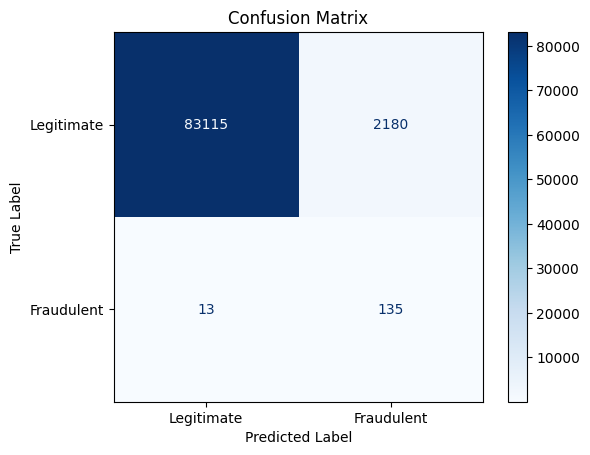

In [ ]:
# Evaluation of the model
evaluation(y_test,y_pred)

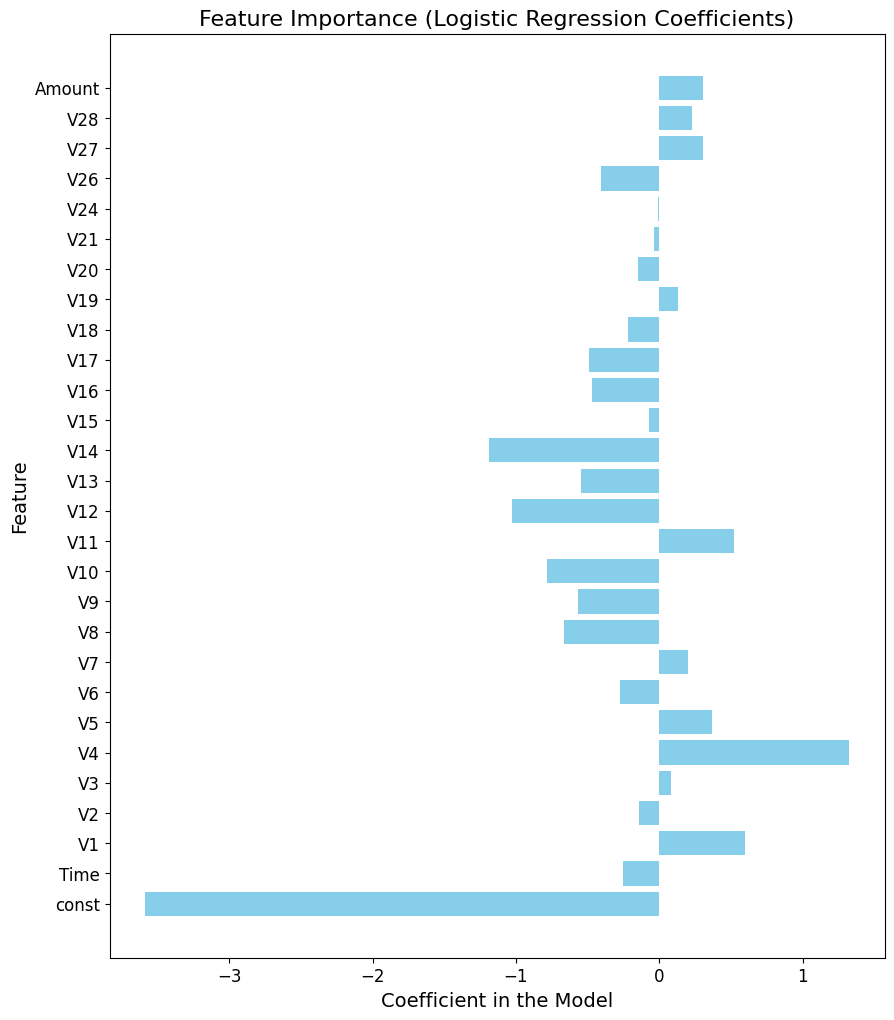

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size and create a horizontal bar plot
plt.figure(figsize=(10, 12))
plt.barh(y=model.params.index, width=model.params.values, color='skyblue')

# Add titles and labels
plt.title('Feature Importance (Logistic Regression Coefficients)', fontsize=16)
plt.xlabel('Coefficient in the Model', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()


We observe that our recall score has imporved considerably in case of a Logistic Regression model. We will further see whether our model could improve through some tree based models

# **Decision Tree**

Since we are using decision tree we won't be needing to scale the split

Evaluation Metrics:
-------------------
Accuracy Score: 0.9857
F1 Score: 0.1769
Precision: 0.0983
Recall: 0.8851

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.10      0.89      0.18       148

    accuracy                           0.99     85443
   macro avg       0.55      0.94      0.58     85443
weighted avg       1.00      0.99      0.99     85443



<Figure size 800x600 with 0 Axes>

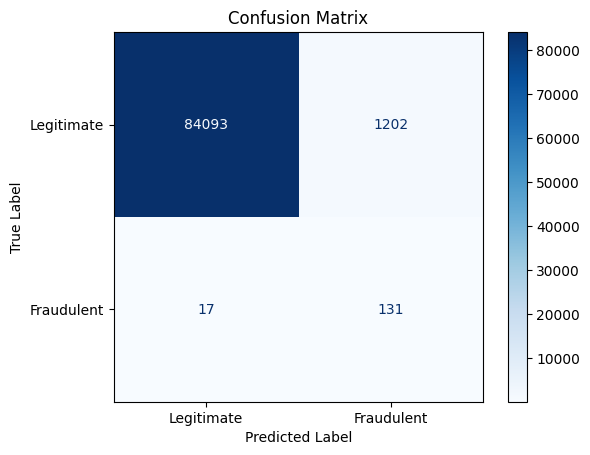

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier

# Resample the training data using SMOTE
x_train_sampled, y_train_sampled = SMOTE().fit_resample(x_train, y_train)

# Initialize and train the Decision Tree classifier
dtree = DecisionTreeClassifier(max_depth=5)
dt_model = dtree.fit(x_train_sampled, y_train_sampled)

# Make predictions on the test set
y_pred = dt_model.predict(x_test)

# Evaluate the model
evaluation(y_test, y_pred)


We observe that Decision Tree performs worse than Losgistic Regression. We will now see whether bossting methods actually have a positive effect on the oversampled train data.

#**Boosting**

In [ ]:
lgbm=LGBMClassifier() # Going with default parameters
lg_model=lgbm.fit(x_train_sampled,y_train_sampled)
y_pred=lg_model.predict(x_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Evaluation Metrics:
-------------------
Accuracy Score: 0.9990
F1 Score: 0.7425
Precision: 0.6667
Recall: 0.8378

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.67      0.84      0.74       148

    accuracy                           1.00     85443
   macro avg       0.83      0.92      0.87     85443
weighted avg       1.00      1.00      1.00     85443



<Figure size 800x600 with 0 Axes>

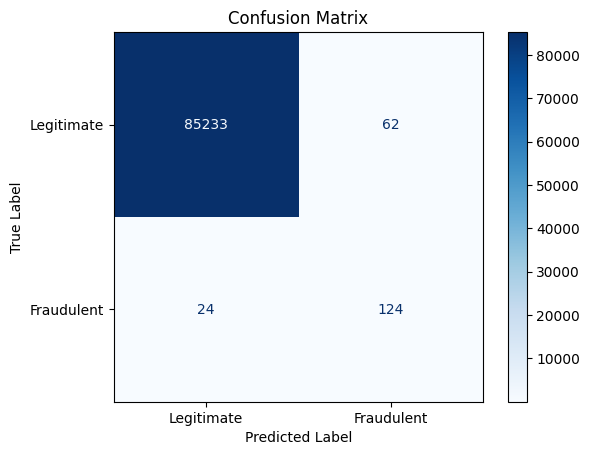

In [ ]:
# Model evaluation
evaluation(y_test,y_pred)

We observe that the lightgbm model is performing poorly compared to Decision Tree in terms of recall score, but has a much better f1-score. Let us see whether we can improve the performance of the lightgbm model by increasing the weight of the positive class

In [ ]:
lgbm=LGBMClassifier(scale_pos_weight=100)
lg_model=lgbm.fit(x_train_sampled,y_train_sampled)
y_pred=lg_model.predict(x_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Evaluation Metrics:
-------------------
Accuracy Score: 0.9955
F1 Score: 0.4013
Precision: 0.2612
Recall: 0.8649

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.26      0.86      0.40       148

    accuracy                           1.00     85443
   macro avg       0.63      0.93      0.70     85443
weighted avg       1.00      1.00      1.00     85443



<Figure size 800x600 with 0 Axes>

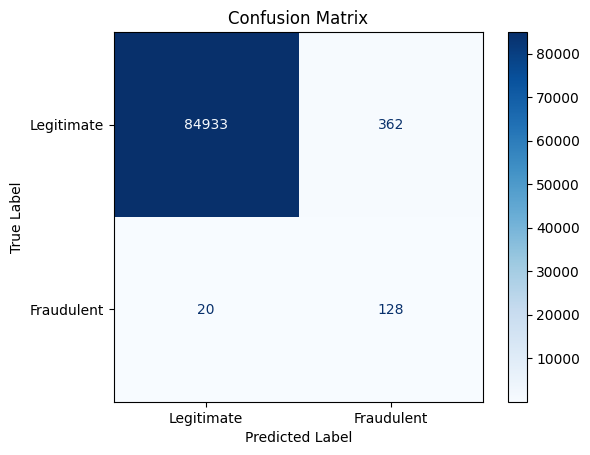

In [ ]:
# Model evaluation
evaluation(y_test,y_pred)

We observe that Lightgbm still doesn't have a better recall score than logistic regression or Decision tree, even with providing a higher weightage to the positive class. Out of all the models we tried so far, Logistic Regression seems to be working the best

#**Conclusion**

* Out of all the models we saw that Logistic Regression worked the best for us in terms of recall score, though the model had a lot of false positives.
  
*  The best method to solve the given problem was applying an oversampling technique(SMOTE) and then applying Logistic regression.
Tree based models seem to be giving a good f1-score but a poor recall score comparitively

*  Boosting methods seem to be performing the best in terms of having the least amount of false positives.
   






